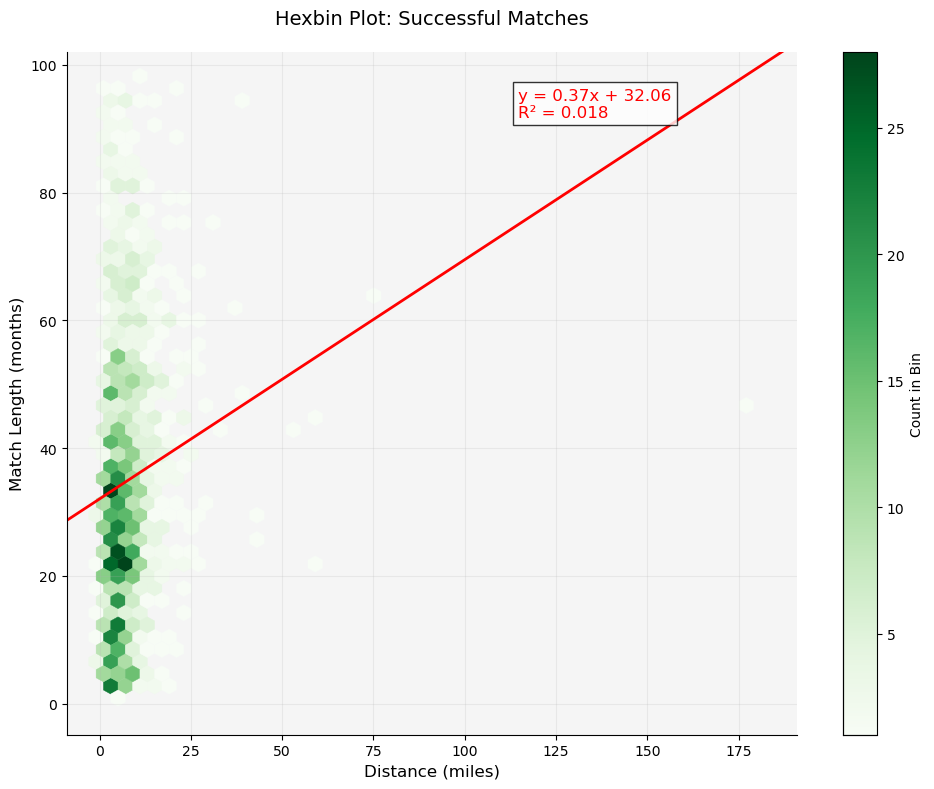

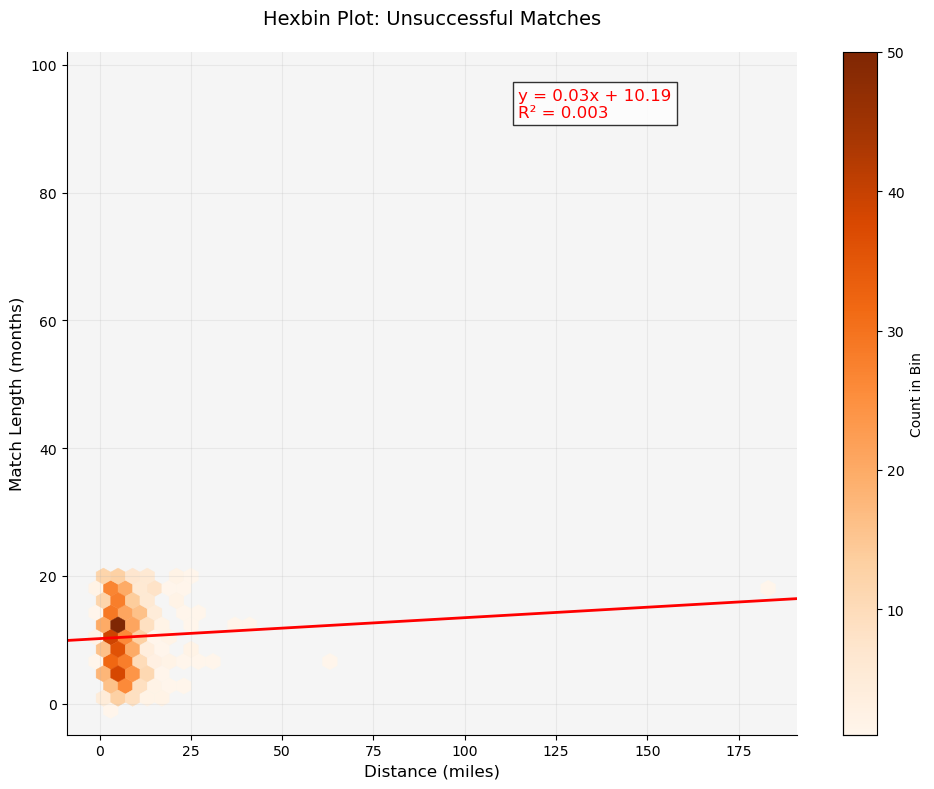

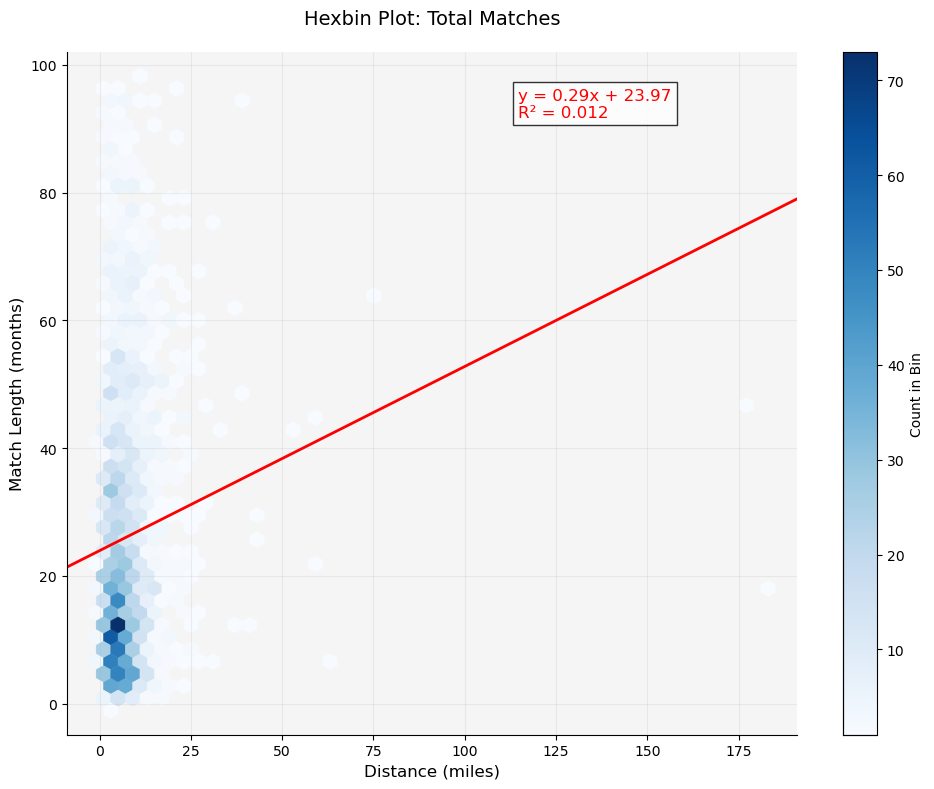


--- Regression Comparison ---
Successful Matches: y = 0.37x + 32.06, R² = 0.018
Unsuccessful Matches: y = 0.03x + 10.19, R² = 0.003

--- ANCOVA / Interaction Effect Test ---
                               sum_sq      df           F         PR(>F)
Distance                  7643.802646     1.0   25.707548   4.315231e-07
is_successful           291747.879699     1.0  981.203082  1.542429e-177
Distance:is_successful    3640.939265     1.0   12.245165   4.760270e-04
Residual                634516.938089  2134.0         NaN            NaN


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load and clean data
df = pd.read_csv('results1.csv')
filtered_df = df[
    (df['Distance'].notna()) & 
    (df['Match Length'].notna()) & 
    (df['Match Length'] != '') & 
    (df['is_successful'].notna())  
].copy()

# Convert columns to numeric
filtered_df['Distance'] = pd.to_numeric(filtered_df['Distance'], errors='coerce')
filtered_df['Match Length'] = pd.to_numeric(filtered_df['Match Length'], errors='coerce')

# Remove invalid values
filtered_df = filtered_df[filtered_df['Distance'] > 0]

# Rename 'Match Length' to avoid issues with spaces
filtered_df = filtered_df.rename(columns={'Match Length': 'Match_Length'})

# Split into successful and unsuccessful matches
df_successful = filtered_df[filtered_df['is_successful'] == True]
df_unsuccessful = filtered_df[filtered_df['is_successful'] == False]
df_total = filtered_df[filtered_df['is_successful'].notna()]

# Calculate global axis limits from ALL data
global_x_min = filtered_df['Distance'].min()
global_x_max = filtered_df['Distance'].max()
global_y_min = filtered_df['Match_Length'].min()
global_y_max = filtered_df['Match_Length'].max()

# Add padding to axis limits
padding_factor = 0.05  # 5% padding
x_padding = (global_x_max - global_x_min) * padding_factor
y_padding = (global_y_max - global_y_min) * padding_factor

global_x_lim = (global_x_min - x_padding, global_x_max + x_padding)
global_y_lim = (global_y_min - y_padding, global_y_max + y_padding)


# Function to compute regression and plot hexbin
def plot_hexbin_and_regression(data, title, cmap):
    if data.empty:
        print(f"No data available for {title}. Skipping plot.")
        return None, None, None
    
    # Compute regression
    slope, intercept, r_value, _, _ = linregress(data['Distance'], data['Match_Length'])
    r_squared = r_value**2  
    regression_eq = f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.3f}"

    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Hexbin plot with consistent limits
    hb = plt.hexbin(data['Distance'], data['Match_Length'],
                    gridsize=50,
                    cmap=cmap,
                    mincnt=1,
                    linewidths=0.3,
                    extent=[*global_x_lim, *global_y_lim])  # Removed 'aspect' parameter
    
    plt.colorbar(hb, label='Count in Bin')
    
    # Set aspect ratio separately
    plt.gca().set_aspect('auto')  # Or 'equal' for 1:1 aspect ratio
    
    # Compute regression
    slope, intercept, r_value, _, _ = linregress(data['Distance'], data['Match_Length'])
    r_squared = r_value**2  
    regression_eq = f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.3f}"

    # Add regression line (clip to plot limits)
    x_vals = np.linspace(global_x_lim[0], global_x_lim[1], 100)
    y_vals = slope * x_vals + intercept
    plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Regression Line')

    # Add regression equation
    plt.text(x=global_x_lim[1] * 0.6, 
             y=global_y_lim[1] * 0.9, 
             s=regression_eq, 
             fontsize=12,
             color='red',
             bbox=dict(facecolor='white', alpha=0.8))

    # Set consistent axis limits
    plt.xlim(global_x_lim)
    plt.ylim(global_y_lim)
    
    # Labels and styling
    plt.xlabel('Distance (miles)', fontsize=12)
    plt.ylabel('Match Length (months)', fontsize=12)
    plt.title(title, fontsize=14, pad=20)
    plt.grid(True, alpha=0.2)
    plt.gca().set_facecolor('#f5f5f5')  # Light gray background
    sns.despine()
    plt.tight_layout()
    
    plt.show()
    
    return slope, intercept, r_squared


# Plot hexbin for successful matches
slope_success, intercept_success, r2_success = plot_hexbin_and_regression(df_successful, 'Hexbin Plot: Successful Matches', 'Greens')

# Plot hexbin for unsuccessful matches
slope_fail, intercept_fail, r2_fail = plot_hexbin_and_regression(df_unsuccessful, 'Hexbin Plot: Unsuccessful Matches', 'Oranges')

slope_total, intercept_total, r2_total = plot_hexbin_and_regression(df_total, 'Hexbin Plot: Total Matches', 'Blues')
# Print regression comparison
print("\n--- Regression Comparison ---")
print(f"Successful Matches: y = {slope_success:.2f}x + {intercept_success:.2f}, R² = {r2_success:.3f}")
print(f"Unsuccessful Matches: y = {slope_fail:.2f}x + {intercept_fail:.2f}, R² = {r2_fail:.3f}")

# -----------------------------------------------------
# Perform ANCOVA / Interaction Regression to Compare
# -----------------------------------------------------
filtered_df['is_successful'] = filtered_df['is_successful'].astype(int)  # Convert boolean to int (0/1)

# Fit an interaction regression model
model = smf.ols("Match_Length ~ Distance * is_successful", data=filtered_df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Print ANCOVA results
print("\n--- ANCOVA / Interaction Effect Test ---")
print(anova_results)
